## 3D Terzaghi Consolidation Problem (PINN)

In [1]:
import os
import numpy as np 
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff
from scianndatagen3dlayered import DataGeneratorXYZT

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [3]:
# ----------------------- Constant Parameters-------------------------
Lx = 1*m
Ly = 1*m
Lz = 1*m

p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., Lx
y_min, y_max = 0., Ly
z_min, z_max = 0., Lz
t_min, t_max = 0., 1.0

NUM_SAMPLES = 10000

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td], 8*[40], 'tanh')

In [5]:
# Generate the training data
dg = DataGeneratorXYZT(
    X=[x_min, x_max],
    Y=[y_min, y_max],
    Z=[z_min, z_max],
    T=[t_min, t_max],
    targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-front', 'bc-back', 'bc-bottom', 'bc-top', 'interface-1-2', 'interface-2-3'],
    num_sample=NUM_SAMPLES,
)

In [6]:
def get_cv(zd):
    return (cv1 * (2/3 <= zd) * (zd <= 1)) + (cv2 * (1/3 <= zd) * (zd < 2/3)) + (cv3 * (0 <= zd) * (zd < 1/3))
    
cv1 = 0.05
cv2 = 0.9
cv3 = 0.001

In [8]:
# 2D Terzaghi Consolidation Problem
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

pd_xy = diff(pd_x, yd)
pd_xyz = diff(pd_xy, zd)

# PDE Equation and BCs
PDE_3D = get_cv(zd)*(pd_xx + pd_yy + pd_zz) - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

# interface_1 = (2/3 <= zd) * (zd < 1)*abs(pd)*cv1 - (1/3 <= zd) * (zd < 2/3)*abs(pd)*cv2
# interface_2 = (1/3 <= zd) * (zd < 2/3)*abs(pd)*cv2 - (0 <= zd) * (zd < 1/3)*abs(pd)*cv3

interface_1 = (zd == 2/3) * abs(pd_xyz)
interface_2 = (zd == 1/3) * abs(pd_xyz)

targets_3D = [sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top, interface_1, interface_2]

input_data_3D, target_data_3D = dg.get_data()

In [9]:
adaptive_weights = {'method': 'NTK', 'freq':200}
epochs = 1000
batch_size = 500

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": epochs
}

In [10]:
train = True
load_weights = not train

# Create and train the model
model = sn.SciModel(
    [xd, yd, zd, td],
    targets_3D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi3D_Layered_4k.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_3D,
        target_data_3D,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        stop_loss_value=1e-8,
        stop_after=None,
        verbose=2,
        adaptive_weights=adaptive_weights
    )

    model.save_weights('Test.hdf5')


Total samples: 9996 
Batch size: 500 
Total batches: 20 


+ NTK evaluation time [s]: 11.553208112716675 

+ adaptive_weights at epoch 1: [0.1122325993202151, 0.18662838588843428, 1.1715791197826482, 0.7251783732320604, 0.8176651886246367, 0.5331829845879886, 1.464120821321687, 2.9233687723065875, 1.058679804667027, 1.0073639502687155]
Epoch 1/1000
20/20 - 9s - loss: 0.1784 - sub_2_loss: 0.0574 - mul_21_loss: 0.6908 - mul_22_loss: 0.0078 - mul_23_loss: 0.0122 - mul_24_loss: 0.0085 - mul_25_loss: 0.0124 - mul_26_loss: 2.8315e-04 - mul_27_loss: 8.3890e-04 - mul_28_loss: 0.0057 - mul_29_loss: 0.0025 - lr: 0.0010 - time: 25.6311 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradien

Epoch 11/1000
20/20 - 1s - loss: 0.1273 - sub_2_loss: 0.1851 - mul_21_loss: 0.4611 - mul_22_loss: 0.0028 - mul_23_loss: 0.0065 - mul_24_loss: 0.0065 - mul_25_loss: 0.0097 - mul_26_loss: 2.3128e-04 - mul_27_loss: 3.4224e-04 - mul_28_loss: 4.0463e-04 - mul_29_loss: 1.8310e-04 - lr: 9.5499e-04 - time: 1.1177 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 56ms/step
Epoch 12/1000
20/20 - 1s - loss: 0.1248 - sub_2_loss: 0.1839 - mul_21_loss: 0.4519 - mul_22_loss: 0.0027 - mul_23_loss: 0.0068 - mul_24_loss: 0.0075 - mul

Epoch 21/1000
20/20 - 1s - loss: 0.1226 - sub_2_loss: 0.2088 - mul_21_loss: 0.4314 - mul_22_loss: 0.0029 - mul_23_loss: 0.0064 - mul_24_loss: 0.0056 - mul_25_loss: 0.0094 - mul_26_loss: 1.2223e-04 - mul_27_loss: 1.2958e-04 - mul_28_loss: 1.9182e-04 - mul_29_loss: 1.7822e-04 - lr: 9.1201e-04 - time: 1.1981 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 60ms/step
Epoch 22/1000
20/20 - 1s - loss: 0.1228 - sub_2_loss: 0.2071 - mul_21_loss: 0.4435 - mul_22_loss: 0.0021 - mul_23_loss: 0.0059 - mul_24_loss: 0.0052 - mul

Epoch 31/1000
20/20 - 1s - loss: 0.1242 - sub_2_loss: 0.2147 - mul_21_loss: 0.4330 - mul_22_loss: 0.0039 - mul_23_loss: 0.0062 - mul_24_loss: 0.0055 - mul_25_loss: 0.0092 - mul_26_loss: 1.5166e-04 - mul_27_loss: 1.2119e-04 - mul_28_loss: 1.1118e-04 - mul_29_loss: 1.4650e-04 - lr: 8.7096e-04 - time: 1.1138 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 56ms/step
Epoch 32/1000
20/20 - 1s - loss: 0.1237 - sub_2_loss: 0.2137 - mul_21_loss: 0.4381 - mul_22_loss: 0.0029 - mul_23_loss: 0.0066 - mul_24_loss: 0.0058 - mul

Epoch 41/1000
20/20 - 1s - loss: 0.1219 - sub_2_loss: 0.2233 - mul_21_loss: 0.4167 - mul_22_loss: 0.0031 - mul_23_loss: 0.0065 - mul_24_loss: 0.0062 - mul_25_loss: 0.0098 - mul_26_loss: 5.1618e-05 - mul_27_loss: 3.7177e-05 - mul_28_loss: 7.7180e-05 - mul_29_loss: 9.1855e-05 - lr: 8.3176e-04 - time: 1.1159 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 56ms/step
Epoch 42/1000
20/20 - 1s - loss: 0.1215 - sub_2_loss: 0.2126 - mul_21_loss: 0.4399 - mul_22_loss: 0.0026 - mul_23_loss: 0.0053 - mul_24_loss: 0.0048 - mul

Epoch 51/1000
20/20 - 1s - loss: 0.1216 - sub_2_loss: 0.2329 - mul_21_loss: 0.4221 - mul_22_loss: 0.0029 - mul_23_loss: 0.0061 - mul_24_loss: 0.0048 - mul_25_loss: 0.0086 - mul_26_loss: 7.9094e-05 - mul_27_loss: 2.7367e-05 - mul_28_loss: 7.5580e-05 - mul_29_loss: 7.5730e-05 - lr: 7.9433e-04 - time: 1.1443 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 57ms/step
Epoch 52/1000
20/20 - 1s - loss: 0.1209 - sub_2_loss: 0.2135 - mul_21_loss: 0.4314 - mul_22_loss: 0.0030 - mul_23_loss: 0.0050 - mul_24_loss: 0.0054 - mul

Epoch 61/1000
20/20 - 1s - loss: 0.1211 - sub_2_loss: 0.2243 - mul_21_loss: 0.4252 - mul_22_loss: 0.0027 - mul_23_loss: 0.0054 - mul_24_loss: 0.0057 - mul_25_loss: 0.0084 - mul_26_loss: 7.0622e-05 - mul_27_loss: 5.9297e-05 - mul_28_loss: 6.7972e-05 - mul_29_loss: 5.9585e-05 - lr: 7.5858e-04 - time: 1.0738 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 54ms/step
Epoch 62/1000
20/20 - 1s - loss: 0.1210 - sub_2_loss: 0.2147 - mul_21_loss: 0.4360 - mul_22_loss: 0.0031 - mul_23_loss: 0.0043 - mul_24_loss: 0.0044 - mul

Epoch 71/1000
20/20 - 1s - loss: 0.1218 - sub_2_loss: 0.2178 - mul_21_loss: 0.4339 - mul_22_loss: 0.0024 - mul_23_loss: 0.0064 - mul_24_loss: 0.0048 - mul_25_loss: 0.0084 - mul_26_loss: 1.0271e-04 - mul_27_loss: 4.4273e-05 - mul_28_loss: 1.2546e-04 - mul_29_loss: 6.3116e-05 - lr: 7.2444e-04 - time: 1.0842 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 54ms/step
Epoch 72/1000
20/20 - 1s - loss: 0.1214 - sub_2_loss: 0.2237 - mul_21_loss: 0.4280 - mul_22_loss: 0.0028 - mul_23_loss: 0.0051 - mul_24_loss: 0.0055 - mul

Epoch 81/1000
20/20 - 1s - loss: 0.1224 - sub_2_loss: 0.2227 - mul_21_loss: 0.4286 - mul_22_loss: 0.0030 - mul_23_loss: 0.0060 - mul_24_loss: 0.0046 - mul_25_loss: 0.0097 - mul_26_loss: 9.1186e-05 - mul_27_loss: 9.6313e-05 - mul_28_loss: 8.7536e-05 - mul_29_loss: 5.6400e-05 - lr: 6.9183e-04 - time: 1.2061 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 60ms/step
Epoch 82/1000
20/20 - 1s - loss: 0.1217 - sub_2_loss: 0.2353 - mul_21_loss: 0.4142 - mul_22_loss: 0.0035 - mul_23_loss: 0.0049 - mul_24_loss: 0.0060 - mul

Epoch 91/1000
20/20 - 1s - loss: 0.1211 - sub_2_loss: 0.2286 - mul_21_loss: 0.4209 - mul_22_loss: 0.0032 - mul_23_loss: 0.0057 - mul_24_loss: 0.0051 - mul_25_loss: 0.0084 - mul_26_loss: 1.1848e-04 - mul_27_loss: 5.4829e-05 - mul_28_loss: 8.3911e-05 - mul_29_loss: 6.2563e-05 - lr: 6.6069e-04 - time: 1.1739 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 59ms/step
Epoch 92/1000
20/20 - 1s - loss: 0.1205 - sub_2_loss: 0.2261 - mul_21_loss: 0.4200 - mul_22_loss: 0.0027 - mul_23_loss: 0.0057 - mul_24_loss: 0.0050 - mul

Epoch 101/1000
20/20 - 1s - loss: 0.1198 - sub_2_loss: 0.2337 - mul_21_loss: 0.4155 - mul_22_loss: 0.0029 - mul_23_loss: 0.0043 - mul_24_loss: 0.0054 - mul_25_loss: 0.0083 - mul_26_loss: 1.5671e-04 - mul_27_loss: 8.8356e-05 - mul_28_loss: 1.1975e-04 - mul_29_loss: 8.1072e-05 - lr: 6.3096e-04 - time: 1.1475 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 57ms/step
Epoch 102/1000
20/20 - 1s - loss: 0.1203 - sub_2_loss: 0.2208 - mul_21_loss: 0.4250 - mul_22_loss: 0.0022 - mul_23_loss: 0.0063 - mul_24_loss: 0.0048 - m

Epoch 111/1000
20/20 - 1s - loss: 0.1209 - sub_2_loss: 0.2184 - mul_21_loss: 0.4270 - mul_22_loss: 0.0030 - mul_23_loss: 0.0047 - mul_24_loss: 0.0054 - mul_25_loss: 0.0088 - mul_26_loss: 9.9979e-05 - mul_27_loss: 9.6964e-05 - mul_28_loss: 7.2823e-05 - mul_29_loss: 7.6005e-05 - lr: 6.0256e-04 - time: 1.1051 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 55ms/step
Epoch 112/1000
20/20 - 1s - loss: 0.1204 - sub_2_loss: 0.2234 - mul_21_loss: 0.4227 - mul_22_loss: 0.0027 - mul_23_loss: 0.0057 - mul_24_loss: 0.0042 - m

Epoch 121/1000
20/20 - 1s - loss: 0.1203 - sub_2_loss: 0.2312 - mul_21_loss: 0.4142 - mul_22_loss: 0.0029 - mul_23_loss: 0.0054 - mul_24_loss: 0.0050 - mul_25_loss: 0.0094 - mul_26_loss: 1.4135e-04 - mul_27_loss: 8.4508e-05 - mul_28_loss: 1.0141e-04 - mul_29_loss: 7.8789e-05 - lr: 5.7544e-04 - time: 1.2665 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 63ms/step
Epoch 122/1000
20/20 - 1s - loss: 0.1201 - sub_2_loss: 0.2339 - mul_21_loss: 0.4124 - mul_22_loss: 0.0026 - mul_23_loss: 0.0055 - mul_24_loss: 0.0056 - m

Epoch 131/1000
20/20 - 1s - loss: 0.1208 - sub_2_loss: 0.2337 - mul_21_loss: 0.4227 - mul_22_loss: 0.0026 - mul_23_loss: 0.0053 - mul_24_loss: 0.0043 - mul_25_loss: 0.0080 - mul_26_loss: 1.6665e-04 - mul_27_loss: 1.7071e-04 - mul_28_loss: 1.6983e-04 - mul_29_loss: 1.2441e-04 - lr: 5.4954e-04 - time: 1.1667 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 58ms/step
Epoch 132/1000
20/20 - 1s - loss: 0.1198 - sub_2_loss: 0.2226 - mul_21_loss: 0.4175 - mul_22_loss: 0.0028 - mul_23_loss: 0.0049 - mul_24_loss: 0.0056 - m

Epoch 141/1000
20/20 - 1s - loss: 0.1199 - sub_2_loss: 0.2245 - mul_21_loss: 0.4160 - mul_22_loss: 0.0028 - mul_23_loss: 0.0058 - mul_24_loss: 0.0052 - mul_25_loss: 0.0088 - mul_26_loss: 1.3782e-04 - mul_27_loss: 1.2158e-04 - mul_28_loss: 1.1696e-04 - mul_29_loss: 1.0231e-04 - lr: 5.2481e-04 - time: 1.0647 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 53ms/step
Epoch 142/1000
20/20 - 1s - loss: 0.1212 - sub_2_loss: 0.2164 - mul_21_loss: 0.4262 - mul_22_loss: 0.0030 - mul_23_loss: 0.0057 - mul_24_loss: 0.0052 - m

Epoch 151/1000
20/20 - 1s - loss: 0.1203 - sub_2_loss: 0.2245 - mul_21_loss: 0.4205 - mul_22_loss: 0.0027 - mul_23_loss: 0.0055 - mul_24_loss: 0.0048 - mul_25_loss: 0.0084 - mul_26_loss: 1.2990e-04 - mul_27_loss: 1.3766e-04 - mul_28_loss: 2.2930e-04 - mul_29_loss: 1.6226e-04 - lr: 5.0119e-04 - time: 1.1481 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 57ms/step
Epoch 152/1000
20/20 - 1s - loss: 0.1202 - sub_2_loss: 0.2245 - mul_21_loss: 0.4196 - mul_22_loss: 0.0026 - mul_23_loss: 0.0052 - mul_24_loss: 0.0050 - m

Epoch 161/1000
20/20 - 1s - loss: 0.1185 - sub_2_loss: 0.2453 - mul_21_loss: 0.3989 - mul_22_loss: 0.0028 - mul_23_loss: 0.0051 - mul_24_loss: 0.0044 - mul_25_loss: 0.0089 - mul_26_loss: 1.6247e-04 - mul_27_loss: 2.4044e-04 - mul_28_loss: 1.4221e-04 - mul_29_loss: 1.5180e-04 - lr: 4.7863e-04 - time: 1.1590 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 58ms/step
Epoch 162/1000
20/20 - 1s - loss: 0.1191 - sub_2_loss: 0.2175 - mul_21_loss: 0.4182 - mul_22_loss: 0.0026 - mul_23_loss: 0.0050 - mul_24_loss: 0.0057 - m

Epoch 171/1000
20/20 - 1s - loss: 0.1179 - sub_2_loss: 0.2209 - mul_21_loss: 0.4100 - mul_22_loss: 0.0025 - mul_23_loss: 0.0049 - mul_24_loss: 0.0052 - mul_25_loss: 0.0084 - mul_26_loss: 1.7614e-04 - mul_27_loss: 1.2820e-04 - mul_28_loss: 3.0558e-04 - mul_29_loss: 2.8903e-04 - lr: 4.5709e-04 - time: 1.1577 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 58ms/step
Epoch 172/1000
20/20 - 1s - loss: 0.1177 - sub_2_loss: 0.2250 - mul_21_loss: 0.4083 - mul_22_loss: 0.0027 - mul_23_loss: 0.0049 - mul_24_loss: 0.0047 - m

Epoch 181/1000
20/20 - 1s - loss: 0.1194 - sub_2_loss: 0.2242 - mul_21_loss: 0.4049 - mul_22_loss: 0.0027 - mul_23_loss: 0.0064 - mul_24_loss: 0.0052 - mul_25_loss: 0.0092 - mul_26_loss: 2.3407e-04 - mul_27_loss: 2.6448e-04 - mul_28_loss: 3.0933e-04 - mul_29_loss: 2.3429e-04 - lr: 4.3652e-04 - time: 1.1643 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 58ms/step
Epoch 182/1000
20/20 - 1s - loss: 0.1190 - sub_2_loss: 0.2130 - mul_21_loss: 0.4138 - mul_22_loss: 0.0030 - mul_23_loss: 0.0051 - mul_24_loss: 0.0049 - m

Epoch 191/1000
20/20 - 1s - loss: 0.1158 - sub_2_loss: 0.2212 - mul_21_loss: 0.3955 - mul_22_loss: 0.0026 - mul_23_loss: 0.0051 - mul_24_loss: 0.0050 - mul_25_loss: 0.0085 - mul_26_loss: 3.2993e-04 - mul_27_loss: 1.8197e-04 - mul_28_loss: 2.9495e-04 - mul_29_loss: 4.0691e-04 - lr: 4.1687e-04 - time: 1.1191 - loss_weight_0: 0.1122 - loss_weight_1: 0.1866 - loss_weight_2: 1.1716 - loss_weight_3: 0.7252 - loss_weight_4: 0.8177 - loss_weight_5: 0.5332 - loss_weight_6: 1.4641 - loss_weight_7: 2.9234 - loss_weight_8: 1.0587 - loss_weight_9: 1.0074 - loss_gradient_0: 2609.6857 - loss_gradient_1: 284.9147 - loss_gradient_2: 75.3830 - loss_gradient_3: 111.9059 - loss_gradient_4: 95.8229 - loss_gradient_5: 133.2782 - loss_gradient_6: 46.2167 - loss_gradient_7: 35.8154 - loss_gradient_8: 93.6384 - loss_gradient_9: 149.5704 - 1s/epoch - 56ms/step
Epoch 192/1000
20/20 - 1s - loss: 0.1150 - sub_2_loss: 0.2170 - mul_21_loss: 0.3951 - mul_22_loss: 0.0027 - mul_23_loss: 0.0043 - mul_24_loss: 0.0050 - m


+ NTK evaluation time [s]: 5.882639646530151 

+ adaptive_weights at epoch 201: [0.015600330879097485, 0.08037033328196988, 0.9306843277867507, 0.6700911317037355, 0.6858900505381644, 0.4117951457202567, 2.3082045419620165, 1.6549950281305654, 1.8415755049521907, 1.4007935946144385]
Epoch 201/1000
20/20 - 1s - loss: 0.0511 - sub_2_loss: 0.2874 - mul_21_loss: 0.3901 - mul_22_loss: 0.0023 - mul_23_loss: 0.0036 - mul_24_loss: 0.0043 - mul_25_loss: 0.0077 - mul_26_loss: 2.8995e-04 - mul_27_loss: 3.8057e-04 - mul_28_loss: 6.3189e-04 - mul_29_loss: 0.0015 - lr: 3.9811e-04 - time: 7.0839 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - los

Epoch 211/1000
20/20 - 1s - loss: 0.0444 - sub_2_loss: 0.5693 - mul_21_loss: 0.3269 - mul_22_loss: 0.0014 - mul_23_loss: 0.0021 - mul_24_loss: 0.0029 - mul_25_loss: 0.0058 - mul_26_loss: 9.0910e-05 - mul_27_loss: 7.3207e-05 - mul_28_loss: 4.7864e-04 - mul_29_loss: 6.4252e-04 - lr: 3.8019e-04 - time: 1.2469 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 62ms/step
Epoch 212/1000
20/20 - 1s - loss: 0.0442 - sub_2_loss: 0.5731 - mul_21_loss: 0.3194 - mul_22_loss: 0.0014 - mul_23_loss: 0.0029 - mul_24_loss: 0.0034 - mul

Epoch 221/1000
20/20 - 1s - loss: 0.0425 - sub_2_loss: 0.5953 - mul_21_loss: 0.3186 - mul_22_loss: 0.0011 - mul_23_loss: 0.0027 - mul_24_loss: 0.0026 - mul_25_loss: 0.0053 - mul_26_loss: 6.9851e-05 - mul_27_loss: 8.6219e-05 - mul_28_loss: 1.7701e-04 - mul_29_loss: 1.8415e-04 - lr: 3.6308e-04 - time: 1.2966 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 65ms/step
Epoch 222/1000
20/20 - 1s - loss: 0.0432 - sub_2_loss: 0.6627 - mul_21_loss: 0.2905 - mul_22_loss: 0.0019 - mul_23_loss: 0.0024 - mul_24_loss: 0.0033 - mul

Epoch 231/1000
20/20 - 1s - loss: 0.0423 - sub_2_loss: 0.6216 - mul_21_loss: 0.3129 - mul_22_loss: 0.0013 - mul_23_loss: 0.0024 - mul_24_loss: 0.0022 - mul_25_loss: 0.0053 - mul_26_loss: 6.9420e-05 - mul_27_loss: 7.7220e-05 - mul_28_loss: 1.9813e-04 - mul_29_loss: 2.3335e-04 - lr: 3.4674e-04 - time: 1.0942 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 55ms/step
Epoch 232/1000
20/20 - 1s - loss: 0.0422 - sub_2_loss: 0.6393 - mul_21_loss: 0.3026 - mul_22_loss: 0.0014 - mul_23_loss: 0.0021 - mul_24_loss: 0.0023 - mul

Epoch 241/1000
20/20 - 1s - loss: 0.0422 - sub_2_loss: 0.6676 - mul_21_loss: 0.2982 - mul_22_loss: 0.0015 - mul_23_loss: 0.0018 - mul_24_loss: 0.0029 - mul_25_loss: 0.0046 - mul_26_loss: 7.4861e-05 - mul_27_loss: 8.8284e-05 - mul_28_loss: 3.0856e-04 - mul_29_loss: 3.0398e-04 - lr: 3.3113e-04 - time: 1.1461 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 242/1000
20/20 - 1s - loss: 0.0418 - sub_2_loss: 0.6278 - mul_21_loss: 0.3065 - mul_22_loss: 0.0011 - mul_23_loss: 0.0024 - mul_24_loss: 0.0020 - mul

Epoch 251/1000
20/20 - 1s - loss: 0.0417 - sub_2_loss: 0.6612 - mul_21_loss: 0.2919 - mul_22_loss: 0.0014 - mul_23_loss: 0.0023 - mul_24_loss: 0.0024 - mul_25_loss: 0.0054 - mul_26_loss: 7.8947e-05 - mul_27_loss: 1.8082e-04 - mul_28_loss: 2.0710e-04 - mul_29_loss: 2.7964e-04 - lr: 3.1623e-04 - time: 1.1435 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 252/1000
20/20 - 1s - loss: 0.0417 - sub_2_loss: 0.6451 - mul_21_loss: 0.2991 - mul_22_loss: 0.0013 - mul_23_loss: 0.0020 - mul_24_loss: 0.0020 - mul

Epoch 261/1000
20/20 - 1s - loss: 0.0415 - sub_2_loss: 0.6593 - mul_21_loss: 0.2945 - mul_22_loss: 0.0016 - mul_23_loss: 0.0020 - mul_24_loss: 0.0027 - mul_25_loss: 0.0051 - mul_26_loss: 5.1512e-05 - mul_27_loss: 8.6527e-05 - mul_28_loss: 1.4285e-04 - mul_29_loss: 2.0508e-04 - lr: 3.0200e-04 - time: 1.1453 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 262/1000
20/20 - 1s - loss: 0.0420 - sub_2_loss: 0.6746 - mul_21_loss: 0.2906 - mul_22_loss: 0.0017 - mul_23_loss: 0.0022 - mul_24_loss: 0.0023 - mul

Epoch 271/1000
20/20 - 1s - loss: 0.0419 - sub_2_loss: 0.6280 - mul_21_loss: 0.3056 - mul_22_loss: 0.0011 - mul_23_loss: 0.0024 - mul_24_loss: 0.0026 - mul_25_loss: 0.0042 - mul_26_loss: 6.3907e-05 - mul_27_loss: 7.1203e-05 - mul_28_loss: 3.9162e-04 - mul_29_loss: 3.1571e-04 - lr: 2.8840e-04 - time: 1.2321 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 62ms/step
Epoch 272/1000
20/20 - 1s - loss: 0.0420 - sub_2_loss: 0.6273 - mul_21_loss: 0.3018 - mul_22_loss: 0.0015 - mul_23_loss: 0.0022 - mul_24_loss: 0.0023 - mul

Epoch 281/1000
20/20 - 1s - loss: 0.0409 - sub_2_loss: 0.6793 - mul_21_loss: 0.2794 - mul_22_loss: 0.0017 - mul_23_loss: 0.0019 - mul_24_loss: 0.0025 - mul_25_loss: 0.0055 - mul_26_loss: 8.2481e-05 - mul_27_loss: 9.1739e-05 - mul_28_loss: 1.3947e-04 - mul_29_loss: 2.8057e-04 - lr: 2.7542e-04 - time: 1.1005 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 55ms/step
Epoch 282/1000
20/20 - 1s - loss: 0.0412 - sub_2_loss: 0.6591 - mul_21_loss: 0.2874 - mul_22_loss: 0.0013 - mul_23_loss: 0.0026 - mul_24_loss: 0.0022 - mul

Epoch 291/1000
20/20 - 1s - loss: 0.0409 - sub_2_loss: 0.6477 - mul_21_loss: 0.2924 - mul_22_loss: 0.0015 - mul_23_loss: 0.0018 - mul_24_loss: 0.0025 - mul_25_loss: 0.0051 - mul_26_loss: 8.0785e-05 - mul_27_loss: 8.0068e-05 - mul_28_loss: 1.9184e-04 - mul_29_loss: 2.1229e-04 - lr: 2.6303e-04 - time: 1.3021 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 65ms/step
Epoch 292/1000
20/20 - 1s - loss: 0.0408 - sub_2_loss: 0.6459 - mul_21_loss: 0.2975 - mul_22_loss: 0.0012 - mul_23_loss: 0.0018 - mul_24_loss: 0.0022 - mul

Epoch 301/1000
20/20 - 1s - loss: 0.0409 - sub_2_loss: 0.6608 - mul_21_loss: 0.2896 - mul_22_loss: 0.0015 - mul_23_loss: 0.0018 - mul_24_loss: 0.0025 - mul_25_loss: 0.0052 - mul_26_loss: 6.6555e-05 - mul_27_loss: 7.7494e-05 - mul_28_loss: 1.4167e-04 - mul_29_loss: 2.1029e-04 - lr: 2.5119e-04 - time: 1.1104 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 56ms/step
Epoch 302/1000
20/20 - 1s - loss: 0.0410 - sub_2_loss: 0.6555 - mul_21_loss: 0.2850 - mul_22_loss: 0.0014 - mul_23_loss: 0.0023 - mul_24_loss: 0.0023 - mul

Epoch 311/1000
20/20 - 1s - loss: 0.0401 - sub_2_loss: 0.6233 - mul_21_loss: 0.2936 - mul_22_loss: 0.0013 - mul_23_loss: 0.0018 - mul_24_loss: 0.0020 - mul_25_loss: 0.0051 - mul_26_loss: 5.5192e-05 - mul_27_loss: 7.5027e-05 - mul_28_loss: 1.1026e-04 - mul_29_loss: 2.3796e-04 - lr: 2.3988e-04 - time: 1.0578 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 53ms/step
Epoch 312/1000
20/20 - 1s - loss: 0.0404 - sub_2_loss: 0.6433 - mul_21_loss: 0.2841 - mul_22_loss: 0.0014 - mul_23_loss: 0.0020 - mul_24_loss: 0.0023 - mul

Epoch 321/1000
20/20 - 1s - loss: 0.0411 - sub_2_loss: 0.6666 - mul_21_loss: 0.2779 - mul_22_loss: 0.0015 - mul_23_loss: 0.0022 - mul_24_loss: 0.0027 - mul_25_loss: 0.0058 - mul_26_loss: 6.5459e-05 - mul_27_loss: 9.8698e-05 - mul_28_loss: 2.4437e-04 - mul_29_loss: 3.4889e-04 - lr: 2.2909e-04 - time: 1.1514 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 58ms/step
Epoch 322/1000
20/20 - 1s - loss: 0.0405 - sub_2_loss: 0.6285 - mul_21_loss: 0.2959 - mul_22_loss: 0.0013 - mul_23_loss: 0.0017 - mul_24_loss: 0.0022 - mul

Epoch 331/1000
20/20 - 1s - loss: 0.0397 - sub_2_loss: 0.6422 - mul_21_loss: 0.2833 - mul_22_loss: 0.0012 - mul_23_loss: 0.0021 - mul_24_loss: 0.0021 - mul_25_loss: 0.0055 - mul_26_loss: 8.0835e-05 - mul_27_loss: 8.0407e-05 - mul_28_loss: 1.2391e-04 - mul_29_loss: 8.3327e-05 - lr: 2.1878e-04 - time: 1.1182 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 56ms/step
Epoch 332/1000
20/20 - 1s - loss: 0.0397 - sub_2_loss: 0.6262 - mul_21_loss: 0.2903 - mul_22_loss: 0.0013 - mul_23_loss: 0.0018 - mul_24_loss: 0.0021 - mul

Epoch 341/1000
20/20 - 1s - loss: 0.0405 - sub_2_loss: 0.6290 - mul_21_loss: 0.2882 - mul_22_loss: 0.0014 - mul_23_loss: 0.0027 - mul_24_loss: 0.0025 - mul_25_loss: 0.0047 - mul_26_loss: 5.7969e-05 - mul_27_loss: 9.6741e-05 - mul_28_loss: 9.8466e-05 - mul_29_loss: 2.3653e-04 - lr: 2.0893e-04 - time: 1.1322 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 342/1000
20/20 - 1s - loss: 0.0397 - sub_2_loss: 0.6333 - mul_21_loss: 0.2816 - mul_22_loss: 0.0014 - mul_23_loss: 0.0020 - mul_24_loss: 0.0021 - mul

Epoch 351/1000
20/20 - 1s - loss: 0.0401 - sub_2_loss: 0.6608 - mul_21_loss: 0.2715 - mul_22_loss: 0.0015 - mul_23_loss: 0.0025 - mul_24_loss: 0.0026 - mul_25_loss: 0.0052 - mul_26_loss: 8.2694e-05 - mul_27_loss: 1.0550e-04 - mul_28_loss: 1.9851e-04 - mul_29_loss: 1.8169e-04 - lr: 1.9953e-04 - time: 1.1499 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 352/1000
20/20 - 1s - loss: 0.0399 - sub_2_loss: 0.6182 - mul_21_loss: 0.2866 - mul_22_loss: 0.0014 - mul_23_loss: 0.0017 - mul_24_loss: 0.0020 - mul

Epoch 361/1000
20/20 - 1s - loss: 0.0397 - sub_2_loss: 0.6419 - mul_21_loss: 0.2729 - mul_22_loss: 0.0014 - mul_23_loss: 0.0024 - mul_24_loss: 0.0020 - mul_25_loss: 0.0060 - mul_26_loss: 7.1077e-05 - mul_27_loss: 1.7145e-04 - mul_28_loss: 1.7677e-04 - mul_29_loss: 1.6065e-04 - lr: 1.9055e-04 - time: 1.0930 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 55ms/step
Epoch 362/1000
20/20 - 1s - loss: 0.0394 - sub_2_loss: 0.6305 - mul_21_loss: 0.2777 - mul_22_loss: 0.0014 - mul_23_loss: 0.0020 - mul_24_loss: 0.0026 - mul

Epoch 371/1000
20/20 - 1s - loss: 0.0407 - sub_2_loss: 0.6177 - mul_21_loss: 0.2851 - mul_22_loss: 0.0013 - mul_23_loss: 0.0025 - mul_24_loss: 0.0020 - mul_25_loss: 0.0054 - mul_26_loss: 7.5848e-05 - mul_27_loss: 1.9127e-04 - mul_28_loss: 3.1028e-04 - mul_29_loss: 4.7583e-04 - lr: 1.8197e-04 - time: 1.1095 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 55ms/step
Epoch 372/1000
20/20 - 1s - loss: 0.0394 - sub_2_loss: 0.6383 - mul_21_loss: 0.2728 - mul_22_loss: 0.0014 - mul_23_loss: 0.0024 - mul_24_loss: 0.0024 - mul

Epoch 381/1000
20/20 - 1s - loss: 0.0406 - sub_2_loss: 0.5978 - mul_21_loss: 0.2916 - mul_22_loss: 0.0014 - mul_23_loss: 0.0016 - mul_24_loss: 0.0020 - mul_25_loss: 0.0048 - mul_26_loss: 9.4731e-05 - mul_27_loss: 1.0893e-04 - mul_28_loss: 1.6538e-04 - mul_29_loss: 0.0011 - lr: 1.7378e-04 - time: 1.1480 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 57ms/step
Epoch 382/1000
20/20 - 1s - loss: 0.0412 - sub_2_loss: 0.6457 - mul_21_loss: 0.2802 - mul_22_loss: 0.0015 - mul_23_loss: 0.0017 - mul_24_loss: 0.0022 - mul_25_

Epoch 391/1000
20/20 - 1s - loss: 0.0389 - sub_2_loss: 0.5915 - mul_21_loss: 0.2872 - mul_22_loss: 0.0012 - mul_23_loss: 0.0024 - mul_24_loss: 0.0021 - mul_25_loss: 0.0046 - mul_26_loss: 6.1730e-05 - mul_27_loss: 7.7562e-05 - mul_28_loss: 1.1982e-04 - mul_29_loss: 1.2070e-04 - lr: 1.6596e-04 - time: 1.1265 - loss_weight_0: 0.0156 - loss_weight_1: 0.0804 - loss_weight_2: 0.9307 - loss_weight_3: 0.6701 - loss_weight_4: 0.6859 - loss_weight_5: 0.4118 - loss_weight_6: 2.3082 - loss_weight_7: 1.6550 - loss_weight_8: 1.8416 - loss_weight_9: 1.4008 - loss_gradient_0: 7776.9248 - loss_gradient_1: 275.7462 - loss_gradient_2: 67.4542 - loss_gradient_3: 81.8297 - loss_gradient_4: 77.1126 - loss_gradient_5: 113.1356 - loss_gradient_6: 26.7912 - loss_gradient_7: 57.7057 - loss_gradient_8: 53.8700 - loss_gradient_9: 87.2333 - 1s/epoch - 56ms/step
Epoch 392/1000
20/20 - 1s - loss: 0.0387 - sub_2_loss: 0.6334 - mul_21_loss: 0.2683 - mul_22_loss: 0.0015 - mul_23_loss: 0.0018 - mul_24_loss: 0.0024 - mul


+ NTK evaluation time [s]: 5.517324447631836 

+ adaptive_weights at epoch 401: [0.0042854243220977785, 0.040030667388219345, 0.8376482509060049, 0.5946807333671283, 0.6361389306630891, 0.32702291228247804, 2.695385075892662, 1.338986041596132, 2.1354412882806586, 1.3903806909477492]
Epoch 401/1000
20/20 - 1s - loss: 0.0201 - sub_2_loss: 0.6484 - mul_21_loss: 0.2867 - mul_22_loss: 0.0013 - mul_23_loss: 0.0017 - mul_24_loss: 0.0020 - mul_25_loss: 0.0046 - mul_26_loss: 5.0950e-05 - mul_27_loss: 1.1385e-04 - mul_28_loss: 1.3880e-04 - mul_29_loss: 2.8899e-04 - lr: 1.5849e-04 - time: 6.7039 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.276

Epoch 411/1000
20/20 - 1s - loss: 0.0200 - sub_2_loss: 0.8187 - mul_21_loss: 0.2792 - mul_22_loss: 0.0010 - mul_23_loss: 0.0011 - mul_24_loss: 0.0014 - mul_25_loss: 0.0036 - mul_26_loss: 4.5690e-05 - mul_27_loss: 7.1452e-05 - mul_28_loss: 4.5857e-04 - mul_29_loss: 3.8178e-04 - lr: 1.5136e-04 - time: 1.0885 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 412/1000
20/20 - 1s - loss: 0.0194 - sub_2_loss: 0.7908 - mul_21_loss: 0.2844 - mul_22_loss: 8.3925e-04 - mul_23_loss: 0.0014 - mul_24_loss: 0.001

Epoch 421/1000
20/20 - 1s - loss: 0.0198 - sub_2_loss: 0.8531 - mul_21_loss: 0.2803 - mul_22_loss: 8.6188e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.0013 - mul_25_loss: 0.0036 - mul_26_loss: 1.2804e-04 - mul_27_loss: 1.6615e-04 - mul_28_loss: 3.0238e-04 - mul_29_loss: 2.1172e-04 - lr: 1.4454e-04 - time: 1.1572 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 58ms/step
Epoch 422/1000
20/20 - 1s - loss: 0.0194 - sub_2_loss: 0.8696 - mul_21_loss: 0.2759 - mul_22_loss: 8.4114e-04 - mul_23_loss: 0.0014 - mul_24_loss: 0

Epoch 431/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9432 - mul_21_loss: 0.2516 - mul_22_loss: 0.0010 - mul_23_loss: 0.0015 - mul_24_loss: 0.0015 - mul_25_loss: 0.0037 - mul_26_loss: 3.5470e-05 - mul_27_loss: 5.9690e-05 - mul_28_loss: 3.1528e-05 - mul_29_loss: 7.4107e-05 - lr: 1.3804e-04 - time: 1.0817 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 432/1000
20/20 - 1s - loss: 0.0186 - sub_2_loss: 0.9096 - mul_21_loss: 0.2723 - mul_22_loss: 8.9800e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.001

Epoch 441/1000
20/20 - 1s - loss: 0.0190 - sub_2_loss: 0.9206 - mul_21_loss: 0.2693 - mul_22_loss: 8.6201e-04 - mul_23_loss: 0.0013 - mul_24_loss: 0.0012 - mul_25_loss: 0.0034 - mul_26_loss: 3.8628e-05 - mul_27_loss: 6.2235e-05 - mul_28_loss: 1.9011e-04 - mul_29_loss: 2.1870e-04 - lr: 1.3183e-04 - time: 1.0900 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 442/1000
20/20 - 1s - loss: 0.0186 - sub_2_loss: 0.9426 - mul_21_loss: 0.2599 - mul_22_loss: 9.3002e-04 - mul_23_loss: 0.0013 - mul_24_loss: 0

Epoch 451/1000
20/20 - 1s - loss: 0.0186 - sub_2_loss: 0.9449 - mul_21_loss: 0.2629 - mul_22_loss: 9.5155e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.0015 - mul_25_loss: 0.0032 - mul_26_loss: 3.2684e-05 - mul_27_loss: 6.1668e-05 - mul_28_loss: 8.4309e-05 - mul_29_loss: 1.5790e-04 - lr: 1.2589e-04 - time: 1.1692 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 59ms/step
Epoch 452/1000
20/20 - 1s - loss: 0.0185 - sub_2_loss: 0.9257 - mul_21_loss: 0.2692 - mul_22_loss: 9.0573e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0

Epoch 461/1000
20/20 - 1s - loss: 0.0187 - sub_2_loss: 0.9575 - mul_21_loss: 0.2625 - mul_22_loss: 8.9753e-04 - mul_23_loss: 0.0013 - mul_24_loss: 0.0012 - mul_25_loss: 0.0034 - mul_26_loss: 4.7680e-05 - mul_27_loss: 6.1419e-05 - mul_28_loss: 1.0122e-04 - mul_29_loss: 1.8617e-04 - lr: 1.2023e-04 - time: 1.0909 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 462/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9377 - mul_21_loss: 0.2703 - mul_22_loss: 9.0087e-04 - mul_23_loss: 9.3893e-04 - mul_24_los

Epoch 471/1000
20/20 - 1s - loss: 0.0182 - sub_2_loss: 0.9827 - mul_21_loss: 0.2580 - mul_22_loss: 9.8986e-04 - mul_23_loss: 0.0010 - mul_24_loss: 0.0013 - mul_25_loss: 0.0032 - mul_26_loss: 2.5302e-05 - mul_27_loss: 5.6500e-05 - mul_28_loss: 3.4408e-05 - mul_29_loss: 5.5290e-05 - lr: 1.1482e-04 - time: 1.1066 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 55ms/step
Epoch 472/1000
20/20 - 1s - loss: 0.0182 - sub_2_loss: 0.9727 - mul_21_loss: 0.2572 - mul_22_loss: 9.0106e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 481/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9759 - mul_21_loss: 0.2592 - mul_22_loss: 8.6660e-04 - mul_23_loss: 0.0013 - mul_24_loss: 0.0013 - mul_25_loss: 0.0031 - mul_26_loss: 3.5973e-05 - mul_27_loss: 5.0208e-05 - mul_28_loss: 1.0505e-04 - mul_29_loss: 8.5468e-05 - lr: 1.0965e-04 - time: 1.2101 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 61ms/step
Epoch 482/1000
20/20 - 1s - loss: 0.0182 - sub_2_loss: 0.9381 - mul_21_loss: 0.2695 - mul_22_loss: 8.1145e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 491/1000
20/20 - 1s - loss: 0.0181 - sub_2_loss: 0.9606 - mul_21_loss: 0.2617 - mul_22_loss: 8.7077e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.0012 - mul_25_loss: 0.0032 - mul_26_loss: 2.7956e-05 - mul_27_loss: 5.1799e-05 - mul_28_loss: 6.0757e-05 - mul_29_loss: 8.9320e-05 - lr: 1.0471e-04 - time: 1.1443 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 57ms/step
Epoch 492/1000
20/20 - 1s - loss: 0.0182 - sub_2_loss: 0.9730 - mul_21_loss: 0.2581 - mul_22_loss: 8.3505e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 501/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9674 - mul_21_loss: 0.2594 - mul_22_loss: 8.8091e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0.0011 - mul_25_loss: 0.0033 - mul_26_loss: 3.2678e-05 - mul_27_loss: 5.3219e-05 - mul_28_loss: 9.4463e-05 - mul_29_loss: 1.9819e-04 - lr: 1.0000e-04 - time: 1.1600 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 58ms/step
Epoch 502/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9726 - mul_21_loss: 0.2579 - mul_22_loss: 8.4885e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 511/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 0.9814 - mul_21_loss: 0.2569 - mul_22_loss: 9.0590e-04 - mul_23_loss: 9.9408e-04 - mul_24_loss: 0.0012 - mul_25_loss: 0.0032 - mul_26_loss: 2.7435e-05 - mul_27_loss: 5.1273e-05 - mul_28_loss: 1.4895e-04 - mul_29_loss: 2.1514e-04 - lr: 9.5499e-05 - time: 1.0752 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 512/1000
20/20 - 1s - loss: 0.0183 - sub_2_loss: 0.9394 - mul_21_loss: 0.2715 - mul_22_loss: 7.6634e-04 - mul_23_loss: 9.0024e-04 - mul_24

Epoch 521/1000
20/20 - 1s - loss: 0.0184 - sub_2_loss: 1.0271 - mul_21_loss: 0.2394 - mul_22_loss: 9.9291e-04 - mul_23_loss: 0.0015 - mul_24_loss: 0.0013 - mul_25_loss: 0.0041 - mul_26_loss: 3.1837e-05 - mul_27_loss: 6.8587e-05 - mul_28_loss: 8.1190e-05 - mul_29_loss: 1.6092e-04 - lr: 9.1201e-05 - time: 1.0577 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 53ms/step
Epoch 522/1000
20/20 - 1s - loss: 0.0185 - sub_2_loss: 0.9699 - mul_21_loss: 0.2645 - mul_22_loss: 8.2685e-04 - mul_23_loss: 8.6261e-04 - mul_24_los

Epoch 531/1000
20/20 - 1s - loss: 0.0179 - sub_2_loss: 0.9852 - mul_21_loss: 0.2553 - mul_22_loss: 8.5283e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0.0011 - mul_25_loss: 0.0031 - mul_26_loss: 3.1518e-05 - mul_27_loss: 4.7487e-05 - mul_28_loss: 3.5560e-05 - mul_29_loss: 4.4193e-05 - lr: 8.7096e-05 - time: 1.1099 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 55ms/step
Epoch 532/1000
20/20 - 1s - loss: 0.0179 - sub_2_loss: 1.0109 - mul_21_loss: 0.2483 - mul_22_loss: 9.2160e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 541/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0055 - mul_21_loss: 0.2541 - mul_22_loss: 8.6054e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.0011 - mul_25_loss: 0.0032 - mul_26_loss: 2.7156e-05 - mul_27_loss: 4.8831e-05 - mul_28_loss: 3.8439e-05 - mul_29_loss: 4.6543e-05 - lr: 8.3176e-05 - time: 1.2206 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 61ms/step
Epoch 542/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0073 - mul_21_loss: 0.2500 - mul_22_loss: 8.5760e-04 - mul_23_loss: 0.0012 - mul_24_loss: 0

Epoch 551/1000
20/20 - 1s - loss: 0.0181 - sub_2_loss: 0.9822 - mul_21_loss: 0.2604 - mul_22_loss: 8.2598e-04 - mul_23_loss: 8.8920e-04 - mul_24_loss: 0.0011 - mul_25_loss: 0.0028 - mul_26_loss: 2.4534e-05 - mul_27_loss: 4.4772e-05 - mul_28_loss: 1.6498e-04 - mul_29_loss: 6.2227e-05 - lr: 7.9433e-05 - time: 1.0711 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 552/1000
20/20 - 1s - loss: 0.0187 - sub_2_loss: 0.9974 - mul_21_loss: 0.2512 - mul_22_loss: 8.9140e-04 - mul_23_loss: 0.0011 - mul_24_los

Epoch 561/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 0.9706 - mul_21_loss: 0.2629 - mul_22_loss: 7.4242e-04 - mul_23_loss: 9.7024e-04 - mul_24_loss: 0.0010 - mul_25_loss: 0.0030 - mul_26_loss: 2.5250e-05 - mul_27_loss: 4.5270e-05 - mul_28_loss: 3.8600e-05 - mul_29_loss: 7.0982e-05 - lr: 7.5858e-05 - time: 1.1461 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 57ms/step
Epoch 562/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0175 - mul_21_loss: 0.2445 - mul_22_loss: 8.7294e-04 - mul_23_loss: 0.0012 - mul_24_los

Epoch 571/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0059 - mul_21_loss: 0.2482 - mul_22_loss: 9.0986e-04 - mul_23_loss: 0.0011 - mul_24_loss: 0.0012 - mul_25_loss: 0.0033 - mul_26_loss: 2.2992e-05 - mul_27_loss: 5.2653e-05 - mul_28_loss: 5.1229e-05 - mul_29_loss: 5.6864e-05 - lr: 7.2444e-05 - time: 1.0691 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 53ms/step
Epoch 572/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0197 - mul_21_loss: 0.2467 - mul_22_loss: 8.6581e-04 - mul_23_loss: 0.0013 - mul_24_loss: 0

Epoch 581/1000
20/20 - 1s - loss: 0.0179 - sub_2_loss: 0.9685 - mul_21_loss: 0.2640 - mul_22_loss: 7.9035e-04 - mul_23_loss: 8.8651e-04 - mul_24_loss: 0.0010 - mul_25_loss: 0.0028 - mul_26_loss: 2.5932e-05 - mul_27_loss: 5.6864e-05 - mul_28_loss: 1.0962e-04 - mul_29_loss: 5.0747e-05 - lr: 6.9183e-05 - time: 1.0763 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 54ms/step
Epoch 582/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0325 - mul_21_loss: 0.2391 - mul_22_loss: 9.2017e-04 - mul_23_loss: 0.0012 - mul_24_los

Epoch 591/1000
20/20 - 1s - loss: 0.0178 - sub_2_loss: 1.0098 - mul_21_loss: 0.2543 - mul_22_loss: 8.2490e-04 - mul_23_loss: 9.5252e-04 - mul_24_loss: 0.0010 - mul_25_loss: 0.0029 - mul_26_loss: 2.3264e-05 - mul_27_loss: 4.6904e-05 - mul_28_loss: 5.6540e-05 - mul_29_loss: 1.0216e-04 - lr: 6.6069e-05 - time: 1.1016 - loss_weight_0: 0.0043 - loss_weight_1: 0.0400 - loss_weight_2: 0.8376 - loss_weight_3: 0.5947 - loss_weight_4: 0.6361 - loss_weight_5: 0.3270 - loss_weight_6: 2.6954 - loss_weight_7: 1.3390 - loss_weight_8: 2.1354 - loss_weight_9: 1.3904 - loss_gradient_0: 15926.1958 - loss_gradient_1: 622.2132 - loss_gradient_2: 84.6444 - loss_gradient_3: 118.6925 - loss_gradient_4: 94.1106 - loss_gradient_5: 177.2767 - loss_gradient_6: 36.2526 - loss_gradient_7: 83.1372 - loss_gradient_8: 65.6976 - loss_gradient_9: 119.2335 - 1s/epoch - 55ms/step
Epoch 592/1000
20/20 - 1s - loss: 0.0180 - sub_2_loss: 1.0189 - mul_21_loss: 0.2458 - mul_22_loss: 8.7075e-04 - mul_23_loss: 0.0011 - mul_24_los


+ NTK evaluation time [s]: 5.250400066375732 

+ adaptive_weights at epoch 601: [0.0024224002842061676, 0.0264623314318405, 0.7934250242312034, 0.5220001282606402, 0.5991826378304231, 0.30326157737687187, 2.9082835825250384, 1.4505362018438956, 2.257159557459879, 1.1372665564742628]
Epoch 601/1000
20/20 - 1s - loss: 0.0123 - sub_2_loss: 0.9564 - mul_21_loss: 0.2687 - mul_22_loss: 7.3709e-04 - mul_23_loss: 8.6271e-04 - mul_24_loss: 9.8600e-04 - mul_25_loss: 0.0026 - mul_26_loss: 2.3258e-05 - mul_27_loss: 4.1031e-05 - mul_28_loss: 8.9857e-05 - mul_29_loss: 1.4281e-04 - lr: 6.3096e-05 - time: 6.3423 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient

Epoch 611/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0119 - mul_21_loss: 0.2655 - mul_22_loss: 6.4977e-04 - mul_23_loss: 9.4337e-04 - mul_24_loss: 8.8741e-04 - mul_25_loss: 0.0025 - mul_26_loss: 1.9870e-05 - mul_27_loss: 4.7935e-05 - mul_28_loss: 3.5546e-05 - mul_29_loss: 5.6085e-05 - lr: 6.0256e-05 - time: 1.1159 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 56ms/step
Epoch 612/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0163 - mul_21_loss: 0.2672 - mul_22_loss: 6.5581e-04 - mul_23_loss: 8.3593e-04 - mu

Epoch 621/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0504 - mul_21_loss: 0.2560 - mul_22_loss: 6.7837e-04 - mul_23_loss: 0.0011 - mul_24_loss: 8.1843e-04 - mul_25_loss: 0.0029 - mul_26_loss: 2.1490e-05 - mul_27_loss: 4.1174e-05 - mul_28_loss: 4.0803e-05 - mul_29_loss: 3.9971e-05 - lr: 5.7544e-05 - time: 1.0954 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 55ms/step
Epoch 622/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0187 - mul_21_loss: 0.2729 - mul_22_loss: 6.1634e-04 - mul_23_loss: 7.6721e-04 - mul_24

Epoch 631/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0512 - mul_21_loss: 0.2638 - mul_22_loss: 6.5109e-04 - mul_23_loss: 8.3853e-04 - mul_24_loss: 7.6833e-04 - mul_25_loss: 0.0024 - mul_26_loss: 1.9007e-05 - mul_27_loss: 4.0924e-05 - mul_28_loss: 2.6391e-05 - mul_29_loss: 5.2408e-05 - lr: 5.4954e-05 - time: 1.0932 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 55ms/step
Epoch 632/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0644 - mul_21_loss: 0.2580 - mul_22_loss: 6.9540e-04 - mul_23_loss: 8.9524e-04 - mu

Epoch 641/1000
20/20 - 1s - loss: 0.0122 - sub_2_loss: 1.0598 - mul_21_loss: 0.2659 - mul_22_loss: 6.4006e-04 - mul_23_loss: 7.5126e-04 - mul_24_loss: 7.7556e-04 - mul_25_loss: 0.0023 - mul_26_loss: 2.4694e-05 - mul_27_loss: 4.2677e-05 - mul_28_loss: 9.3011e-05 - mul_29_loss: 1.7604e-04 - lr: 5.2481e-05 - time: 1.1466 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 57ms/step
Epoch 642/1000
20/20 - 1s - loss: 0.0122 - sub_2_loss: 1.0710 - mul_21_loss: 0.2589 - mul_22_loss: 6.4809e-04 - mul_23_loss: 8.3530e-04 - mu

Epoch 651/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0723 - mul_21_loss: 0.2619 - mul_22_loss: 6.1912e-04 - mul_23_loss: 8.8663e-04 - mul_24_loss: 8.0585e-04 - mul_25_loss: 0.0023 - mul_26_loss: 2.0699e-05 - mul_27_loss: 4.2099e-05 - mul_28_loss: 7.0742e-05 - mul_29_loss: 7.6819e-05 - lr: 5.0119e-05 - time: 1.0570 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 53ms/step
Epoch 652/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0858 - mul_21_loss: 0.2600 - mul_22_loss: 6.8465e-04 - mul_23_loss: 7.8956e-04 - mu

Epoch 661/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.0744 - mul_21_loss: 0.2638 - mul_22_loss: 6.2217e-04 - mul_23_loss: 7.5883e-04 - mul_24_loss: 7.5199e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.8449e-05 - mul_27_loss: 3.8306e-05 - mul_28_loss: 2.6467e-05 - mul_29_loss: 4.4473e-05 - lr: 4.7863e-05 - time: 1.0834 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 54ms/step
Epoch 662/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0796 - mul_21_loss: 0.2612 - mul_22_loss: 6.1721e-04 - mul_23_loss: 8.2808e-04 - mu

Epoch 671/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.0881 - mul_21_loss: 0.2594 - mul_22_loss: 6.5933e-04 - mul_23_loss: 7.6163e-04 - mul_24_loss: 7.8756e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.9650e-05 - mul_27_loss: 3.7072e-05 - mul_28_loss: 3.4084e-05 - mul_29_loss: 4.5921e-05 - lr: 4.5709e-05 - time: 1.0763 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 54ms/step
Epoch 672/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0852 - mul_21_loss: 0.2637 - mul_22_loss: 6.1836e-04 - mul_23_loss: 7.8605e-04 - mu

Epoch 681/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.1071 - mul_21_loss: 0.2551 - mul_22_loss: 6.6576e-04 - mul_23_loss: 8.2656e-04 - mul_24_loss: 7.6884e-04 - mul_25_loss: 0.0024 - mul_26_loss: 1.9174e-05 - mul_27_loss: 3.7979e-05 - mul_28_loss: 3.2866e-05 - mul_29_loss: 4.2052e-05 - lr: 4.3652e-05 - time: 1.0560 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 53ms/step
Epoch 682/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0777 - mul_21_loss: 0.2669 - mul_22_loss: 5.8478e-04 - mul_23_loss: 7.5856e-04 - mu

Epoch 691/1000
20/20 - 1s - loss: 0.0120 - sub_2_loss: 1.0817 - mul_21_loss: 0.2641 - mul_22_loss: 5.7569e-04 - mul_23_loss: 8.5042e-04 - mul_24_loss: 6.5987e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.8200e-05 - mul_27_loss: 4.4938e-05 - mul_28_loss: 9.1858e-05 - mul_29_loss: 7.4999e-05 - lr: 4.1687e-05 - time: 1.0489 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 52ms/step
Epoch 692/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0845 - mul_21_loss: 0.2645 - mul_22_loss: 5.9238e-04 - mul_23_loss: 7.8003e-04 - mu

Epoch 701/1000
20/20 - 1s - loss: 0.0119 - sub_2_loss: 1.0816 - mul_21_loss: 0.2625 - mul_22_loss: 6.2207e-04 - mul_23_loss: 6.9054e-04 - mul_24_loss: 7.5336e-04 - mul_25_loss: 0.0022 - mul_26_loss: 1.9605e-05 - mul_27_loss: 3.7815e-05 - mul_28_loss: 6.8414e-05 - mul_29_loss: 7.0905e-05 - lr: 3.9811e-05 - time: 1.1393 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 57ms/step
Epoch 702/1000
20/20 - 1s - loss: 0.0122 - sub_2_loss: 1.1135 - mul_21_loss: 0.2571 - mul_22_loss: 6.2475e-04 - mul_23_loss: 7.7856e-04 - mu

Epoch 711/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.1038 - mul_21_loss: 0.2565 - mul_22_loss: 5.9789e-04 - mul_23_loss: 8.9207e-04 - mul_24_loss: 7.4590e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.9722e-05 - mul_27_loss: 3.6803e-05 - mul_28_loss: 2.7360e-05 - mul_29_loss: 4.6451e-05 - lr: 3.8019e-05 - time: 1.0787 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 54ms/step
Epoch 712/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.0974 - mul_21_loss: 0.2625 - mul_22_loss: 6.1774e-04 - mul_23_loss: 7.2000e-04 - mu

Epoch 721/1000
20/20 - 1s - loss: 0.0118 - sub_2_loss: 1.1176 - mul_21_loss: 0.2572 - mul_22_loss: 6.1999e-04 - mul_23_loss: 7.9085e-04 - mul_24_loss: 7.8069e-04 - mul_25_loss: 0.0022 - mul_26_loss: 1.6778e-05 - mul_27_loss: 3.4264e-05 - mul_28_loss: 2.7497e-05 - mul_29_loss: 3.9477e-05 - lr: 3.6308e-05 - time: 1.0426 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 52ms/step
Epoch 722/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1121 - mul_21_loss: 0.2572 - mul_22_loss: 6.1561e-04 - mul_23_loss: 7.9354e-04 - mu

Epoch 731/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1052 - mul_21_loss: 0.2585 - mul_22_loss: 6.1524e-04 - mul_23_loss: 7.3798e-04 - mul_24_loss: 7.6493e-04 - mul_25_loss: 0.0022 - mul_26_loss: 2.0589e-05 - mul_27_loss: 3.9069e-05 - mul_28_loss: 2.1663e-05 - mul_29_loss: 3.7639e-05 - lr: 3.4674e-05 - time: 1.1588 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 58ms/step
Epoch 732/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1162 - mul_21_loss: 0.2543 - mul_22_loss: 6.2086e-04 - mul_23_loss: 8.4253e-04 - mu

Epoch 741/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1092 - mul_21_loss: 0.2562 - mul_22_loss: 6.0082e-04 - mul_23_loss: 8.2758e-04 - mul_24_loss: 7.2022e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.7403e-05 - mul_27_loss: 3.3588e-05 - mul_28_loss: 2.4748e-05 - mul_29_loss: 3.9277e-05 - lr: 3.3113e-05 - time: 1.0583 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 53ms/step
Epoch 742/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1250 - mul_21_loss: 0.2510 - mul_22_loss: 6.2887e-04 - mul_23_loss: 8.3878e-04 - mu

Epoch 751/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1151 - mul_21_loss: 0.2571 - mul_22_loss: 5.8303e-04 - mul_23_loss: 7.6519e-04 - mul_24_loss: 7.4614e-04 - mul_25_loss: 0.0022 - mul_26_loss: 1.7126e-05 - mul_27_loss: 3.5192e-05 - mul_28_loss: 2.4671e-05 - mul_29_loss: 4.1071e-05 - lr: 3.1623e-05 - time: 1.1063 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 55ms/step
Epoch 752/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1180 - mul_21_loss: 0.2571 - mul_22_loss: 5.9505e-04 - mul_23_loss: 7.2974e-04 - mu

Epoch 761/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1157 - mul_21_loss: 0.2558 - mul_22_loss: 6.0233e-04 - mul_23_loss: 7.8425e-04 - mul_24_loss: 7.2376e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.7375e-05 - mul_27_loss: 3.9397e-05 - mul_28_loss: 1.9046e-05 - mul_29_loss: 3.9195e-05 - lr: 3.0200e-05 - time: 1.1374 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 57ms/step
Epoch 762/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1092 - mul_21_loss: 0.2593 - mul_22_loss: 6.0139e-04 - mul_23_loss: 6.9532e-04 - mu

Epoch 771/1000
20/20 - 1s - loss: 0.0116 - sub_2_loss: 1.1267 - mul_21_loss: 0.2521 - mul_22_loss: 6.0224e-04 - mul_23_loss: 8.1501e-04 - mul_24_loss: 7.2787e-04 - mul_25_loss: 0.0024 - mul_26_loss: 1.7271e-05 - mul_27_loss: 3.5048e-05 - mul_28_loss: 2.0310e-05 - mul_29_loss: 3.6260e-05 - lr: 2.8840e-05 - time: 1.0513 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 53ms/step
Epoch 772/1000
20/20 - 1s - loss: 0.0116 - sub_2_loss: 1.1203 - mul_21_loss: 0.2553 - mul_22_loss: 5.8566e-04 - mul_23_loss: 7.7228e-04 - mu

Epoch 781/1000
20/20 - 1s - loss: 0.0117 - sub_2_loss: 1.1319 - mul_21_loss: 0.2524 - mul_22_loss: 6.0895e-04 - mul_23_loss: 8.2313e-04 - mul_24_loss: 7.2823e-04 - mul_25_loss: 0.0023 - mul_26_loss: 1.6586e-05 - mul_27_loss: 3.6923e-05 - mul_28_loss: 2.9209e-05 - mul_29_loss: 3.8249e-05 - lr: 2.7542e-05 - time: 1.0909 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 55ms/step
Epoch 782/1000
20/20 - 1s - loss: 0.0116 - sub_2_loss: 1.1211 - mul_21_loss: 0.2562 - mul_22_loss: 5.8206e-04 - mul_23_loss: 7.4444e-04 - mu

Epoch 791/1000
20/20 - 1s - loss: 0.0116 - sub_2_loss: 1.1148 - mul_21_loss: 0.2597 - mul_22_loss: 5.7400e-04 - mul_23_loss: 7.0033e-04 - mul_24_loss: 6.8725e-04 - mul_25_loss: 0.0021 - mul_26_loss: 1.7681e-05 - mul_27_loss: 3.5514e-05 - mul_28_loss: 1.7711e-05 - mul_29_loss: 3.5700e-05 - lr: 2.6303e-05 - time: 1.1238 - loss_weight_0: 0.0024 - loss_weight_1: 0.0265 - loss_weight_2: 0.7934 - loss_weight_3: 0.5220 - loss_weight_4: 0.5992 - loss_weight_5: 0.3033 - loss_weight_6: 2.9083 - loss_weight_7: 1.4505 - loss_weight_8: 2.2572 - loss_weight_9: 1.1373 - loss_gradient_0: 23018.8184 - loss_gradient_1: 880.6622 - loss_gradient_2: 86.1598 - loss_gradient_3: 147.3846 - loss_gradient_4: 96.9322 - loss_gradient_5: 188.9693 - loss_gradient_6: 39.5384 - loss_gradient_7: 74.1151 - loss_gradient_8: 66.2561 - loss_gradient_9: 158.8063 - 1s/epoch - 56ms/step
Epoch 792/1000
20/20 - 1s - loss: 0.0116 - sub_2_loss: 1.1329 - mul_21_loss: 0.2528 - mul_22_loss: 5.9116e-04 - mul_23_loss: 7.8468e-04 - mu


+ NTK evaluation time [s]: 5.117700099945068 

+ adaptive_weights at epoch 801: [0.0019703681531378194, 0.023797664950469165, 0.8024084670231939, 0.5092028051451892, 0.6024415365921868, 0.30912641541888897, 3.01956868400909, 1.6055278888928481, 2.168553845954077, 0.9574023082612675]
Epoch 801/1000
20/20 - 1s - loss: 0.0106 - sub_2_loss: 1.1372 - mul_21_loss: 0.2517 - mul_22_loss: 6.1084e-04 - mul_23_loss: 7.7863e-04 - mul_24_loss: 6.9574e-04 - mul_25_loss: 0.0023 - mul_26_loss: 2.0259e-05 - mul_27_loss: 3.2902e-05 - mul_28_loss: 5.7000e-05 - mul_29_loss: 9.1904e-05 - lr: 2.5119e-05 - time: 6.1813 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient

Epoch 811/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1642 - mul_21_loss: 0.2501 - mul_22_loss: 5.8859e-04 - mul_23_loss: 8.0278e-04 - mul_24_loss: 6.8790e-04 - mul_25_loss: 0.0022 - mul_26_loss: 1.6886e-05 - mul_27_loss: 3.4052e-05 - mul_28_loss: 1.6699e-05 - mul_29_loss: 2.9946e-05 - lr: 2.3988e-05 - time: 1.1410 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 57ms/step
Epoch 812/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1461 - mul_21_loss: 0.2581 - mul_22_loss: 5.5673e-04 - mul_23_loss: 7.0381e-04 - mu

Epoch 821/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1558 - mul_21_loss: 0.2562 - mul_22_loss: 5.4762e-04 - mul_23_loss: 7.1448e-04 - mul_24_loss: 6.5666e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.7071e-05 - mul_27_loss: 3.3476e-05 - mul_28_loss: 2.0566e-05 - mul_29_loss: 4.8052e-05 - lr: 2.2909e-05 - time: 1.0849 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 54ms/step
Epoch 822/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1572 - mul_21_loss: 0.2586 - mul_22_loss: 5.4008e-04 - mul_23_loss: 6.6372e-04 - mu

Epoch 831/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1685 - mul_21_loss: 0.2560 - mul_22_loss: 5.5316e-04 - mul_23_loss: 6.7836e-04 - mul_24_loss: 6.3954e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.7652e-05 - mul_27_loss: 3.4507e-05 - mul_28_loss: 2.2186e-05 - mul_29_loss: 3.5468e-05 - lr: 2.1878e-05 - time: 1.1271 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 56ms/step
Epoch 832/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1679 - mul_21_loss: 0.2574 - mul_22_loss: 5.5607e-04 - mul_23_loss: 6.7664e-04 - mu

Epoch 841/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1849 - mul_21_loss: 0.2529 - mul_22_loss: 5.5153e-04 - mul_23_loss: 6.9272e-04 - mul_24_loss: 6.5617e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6370e-05 - mul_27_loss: 3.3112e-05 - mul_28_loss: 1.7352e-05 - mul_29_loss: 3.3554e-05 - lr: 2.0893e-05 - time: 1.1017 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 55ms/step
Epoch 842/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1764 - mul_21_loss: 0.2534 - mul_22_loss: 5.7510e-04 - mul_23_loss: 6.9585e-04 - mu

Epoch 851/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1635 - mul_21_loss: 0.2590 - mul_22_loss: 5.2832e-04 - mul_23_loss: 6.6646e-04 - mul_24_loss: 6.1915e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.8398e-05 - mul_27_loss: 3.1760e-05 - mul_28_loss: 1.8317e-05 - mul_29_loss: 3.0372e-05 - lr: 1.9953e-05 - time: 1.0637 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 53ms/step
Epoch 852/1000
20/20 - 1s - loss: 0.0104 - sub_2_loss: 1.1894 - mul_21_loss: 0.2503 - mul_22_loss: 5.5322e-04 - mul_23_loss: 7.6818e-04 - mu

Epoch 861/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1784 - mul_21_loss: 0.2549 - mul_22_loss: 5.3392e-04 - mul_23_loss: 6.8288e-04 - mul_24_loss: 6.3565e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.7232e-05 - mul_27_loss: 3.3427e-05 - mul_28_loss: 1.8657e-05 - mul_29_loss: 3.8561e-05 - lr: 1.9055e-05 - time: 1.1252 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 56ms/step
Epoch 862/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1888 - mul_21_loss: 0.2521 - mul_22_loss: 5.4541e-04 - mul_23_loss: 6.9701e-04 - mu

Epoch 871/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1933 - mul_21_loss: 0.2518 - mul_22_loss: 5.4260e-04 - mul_23_loss: 7.2213e-04 - mul_24_loss: 6.4120e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6493e-05 - mul_27_loss: 3.1931e-05 - mul_28_loss: 1.6265e-05 - mul_29_loss: 3.5765e-05 - lr: 1.8197e-05 - time: 1.1427 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 57ms/step
Epoch 872/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1823 - mul_21_loss: 0.2564 - mul_22_loss: 5.2692e-04 - mul_23_loss: 6.4461e-04 - mu

Epoch 881/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1900 - mul_21_loss: 0.2533 - mul_22_loss: 5.4297e-04 - mul_23_loss: 6.8634e-04 - mul_24_loss: 6.2936e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.5994e-05 - mul_27_loss: 3.0931e-05 - mul_28_loss: 2.3461e-05 - mul_29_loss: 3.8865e-05 - lr: 1.7378e-05 - time: 1.0903 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 55ms/step
Epoch 882/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2039 - mul_21_loss: 0.2478 - mul_22_loss: 5.7204e-04 - mul_23_loss: 7.2497e-04 - mu

Epoch 891/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1978 - mul_21_loss: 0.2515 - mul_22_loss: 5.3216e-04 - mul_23_loss: 6.9975e-04 - mul_24_loss: 6.1912e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6662e-05 - mul_27_loss: 3.2084e-05 - mul_28_loss: 1.6304e-05 - mul_29_loss: 3.1858e-05 - lr: 1.6596e-05 - time: 1.0970 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 55ms/step
Epoch 892/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2000 - mul_21_loss: 0.2513 - mul_22_loss: 5.3754e-04 - mul_23_loss: 6.8400e-04 - mu

Epoch 901/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.1976 - mul_21_loss: 0.2531 - mul_22_loss: 5.2216e-04 - mul_23_loss: 6.9685e-04 - mul_24_loss: 6.1210e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6116e-05 - mul_27_loss: 3.0855e-05 - mul_28_loss: 1.5097e-05 - mul_29_loss: 3.7222e-05 - lr: 1.5849e-05 - time: 1.0721 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 54ms/step
Epoch 902/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2042 - mul_21_loss: 0.2515 - mul_22_loss: 5.2990e-04 - mul_23_loss: 7.0285e-04 - mu

Epoch 911/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2067 - mul_21_loss: 0.2483 - mul_22_loss: 5.5387e-04 - mul_23_loss: 7.2046e-04 - mul_24_loss: 6.1424e-04 - mul_25_loss: 0.0021 - mul_26_loss: 1.6754e-05 - mul_27_loss: 3.1673e-05 - mul_28_loss: 2.3897e-05 - mul_29_loss: 3.4504e-05 - lr: 1.5136e-05 - time: 1.1077 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 55ms/step
Epoch 912/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2026 - mul_21_loss: 0.2515 - mul_22_loss: 5.2431e-04 - mul_23_loss: 6.8763e-04 - mu

Epoch 921/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2015 - mul_21_loss: 0.2532 - mul_22_loss: 5.1848e-04 - mul_23_loss: 6.5269e-04 - mul_24_loss: 6.0238e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.5741e-05 - mul_27_loss: 3.0092e-05 - mul_28_loss: 1.8289e-05 - mul_29_loss: 3.2915e-05 - lr: 1.4454e-05 - time: 1.1725 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 59ms/step
Epoch 922/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2011 - mul_21_loss: 0.2510 - mul_22_loss: 5.3939e-04 - mul_23_loss: 6.8292e-04 - mu

Epoch 931/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2068 - mul_21_loss: 0.2514 - mul_22_loss: 5.2414e-04 - mul_23_loss: 6.6373e-04 - mul_24_loss: 6.0427e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.5956e-05 - mul_27_loss: 3.0400e-05 - mul_28_loss: 1.5780e-05 - mul_29_loss: 3.2761e-05 - lr: 1.3804e-05 - time: 1.1156 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 56ms/step
Epoch 932/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2043 - mul_21_loss: 0.2509 - mul_22_loss: 5.2519e-04 - mul_23_loss: 6.7914e-04 - mu

Epoch 941/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2124 - mul_21_loss: 0.2505 - mul_22_loss: 5.2502e-04 - mul_23_loss: 6.7618e-04 - mul_24_loss: 6.1098e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.5978e-05 - mul_27_loss: 2.9928e-05 - mul_28_loss: 1.6186e-05 - mul_29_loss: 3.0683e-05 - lr: 1.3183e-05 - time: 1.0899 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 54ms/step
Epoch 942/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2013 - mul_21_loss: 0.2559 - mul_22_loss: 4.9535e-04 - mul_23_loss: 6.3281e-04 - mu

Epoch 951/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2041 - mul_21_loss: 0.2534 - mul_22_loss: 5.0676e-04 - mul_23_loss: 6.3740e-04 - mul_24_loss: 5.9606e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.5865e-05 - mul_27_loss: 2.9940e-05 - mul_28_loss: 1.6453e-05 - mul_29_loss: 3.4797e-05 - lr: 1.2589e-05 - time: 1.1234 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 56ms/step
Epoch 952/1000
20/20 - 1s - loss: 0.0103 - sub_2_loss: 1.2184 - mul_21_loss: 0.2486 - mul_22_loss: 5.2591e-04 - mul_23_loss: 7.2232e-04 - mu

Epoch 961/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2150 - mul_21_loss: 0.2502 - mul_22_loss: 5.2070e-04 - mul_23_loss: 6.6435e-04 - mul_24_loss: 6.2408e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.6574e-05 - mul_27_loss: 3.0238e-05 - mul_28_loss: 1.6033e-05 - mul_29_loss: 3.8584e-05 - lr: 1.2023e-05 - time: 1.1358 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 57ms/step
Epoch 962/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2184 - mul_21_loss: 0.2503 - mul_22_loss: 5.1236e-04 - mul_23_loss: 6.6028e-04 - mu

Epoch 971/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2174 - mul_21_loss: 0.2490 - mul_22_loss: 5.0733e-04 - mul_23_loss: 7.0474e-04 - mul_24_loss: 5.9317e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6560e-05 - mul_27_loss: 3.1151e-05 - mul_28_loss: 1.4946e-05 - mul_29_loss: 3.6005e-05 - lr: 1.1482e-05 - time: 1.1249 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 56ms/step
Epoch 972/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2198 - mul_21_loss: 0.2488 - mul_22_loss: 5.2055e-04 - mul_23_loss: 6.7620e-04 - mu

Epoch 981/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2158 - mul_21_loss: 0.2511 - mul_22_loss: 5.1151e-04 - mul_23_loss: 6.7351e-04 - mul_24_loss: 5.9973e-04 - mul_25_loss: 0.0019 - mul_26_loss: 1.6451e-05 - mul_27_loss: 2.9719e-05 - mul_28_loss: 1.4851e-05 - mul_29_loss: 2.9252e-05 - lr: 1.0965e-05 - time: 1.1955 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 60ms/step
Epoch 982/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2161 - mul_21_loss: 0.2500 - mul_22_loss: 5.1301e-04 - mul_23_loss: 6.6530e-04 - mu

Epoch 991/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2171 - mul_21_loss: 0.2502 - mul_22_loss: 5.1891e-04 - mul_23_loss: 6.5549e-04 - mul_24_loss: 5.8110e-04 - mul_25_loss: 0.0020 - mul_26_loss: 1.6136e-05 - mul_27_loss: 2.9601e-05 - mul_28_loss: 1.3604e-05 - mul_29_loss: 3.1844e-05 - lr: 1.0471e-05 - time: 1.0687 - loss_weight_0: 0.0020 - loss_weight_1: 0.0238 - loss_weight_2: 0.8024 - loss_weight_3: 0.5092 - loss_weight_4: 0.6024 - loss_weight_5: 0.3091 - loss_weight_6: 3.0196 - loss_weight_7: 1.6055 - loss_weight_8: 2.1686 - loss_weight_9: 0.9574 - loss_gradient_0: 29006.8964 - loss_gradient_1: 969.9027 - loss_gradient_2: 86.6251 - loss_gradient_3: 159.4563 - loss_gradient_4: 98.1686 - loss_gradient_5: 189.4589 - loss_gradient_6: 41.9376 - loss_gradient_7: 68.8238 - loss_gradient_8: 74.8456 - loss_gradient_9: 202.0449 - 1s/epoch - 53ms/step
Epoch 992/1000
20/20 - 1s - loss: 0.0102 - sub_2_loss: 1.2261 - mul_21_loss: 0.2470 - mul_22_loss: 5.3313e-04 - mul_23_loss: 6.9230e-04 - mu

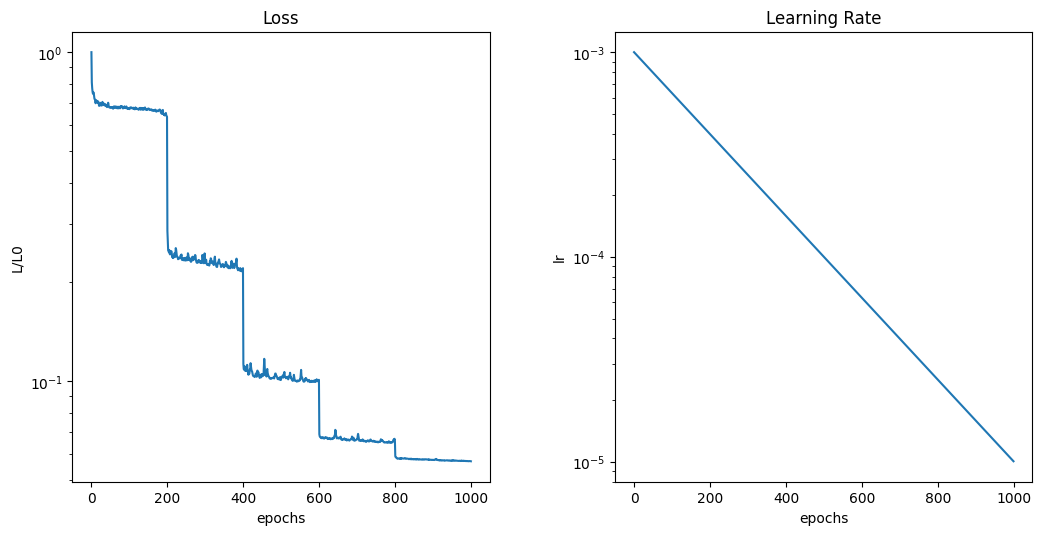

In [11]:
if train:
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Epochs_3D.png',dpi=600)
    plt.show()

### PINN and Exact Solution

In [14]:
# Define the evaluation grid
N = 30 # Grid number
Nx = Ny = Nz = N
Nt = 21600
xs = np.linspace(x_min, x_max, Nx)
ys = np.linspace(y_min, y_max, Ny)
zs = np.linspace(z_min, z_max, Nz)
ts = np.linspace(t_min, t_max, Nt)

# # Define the directory to save the pore pressure data
# save_directory = r'C:\Users\Umar\OneDrive\UROP_PINNs\Terzaghi\Forward\Data'
# os.makedirs(save_directory, exist_ok=True)

# # Load pore pressure data from the file
# u_loaded = np.load(os.path.join(save_directory, f'3d_layered_{N}.npy'))

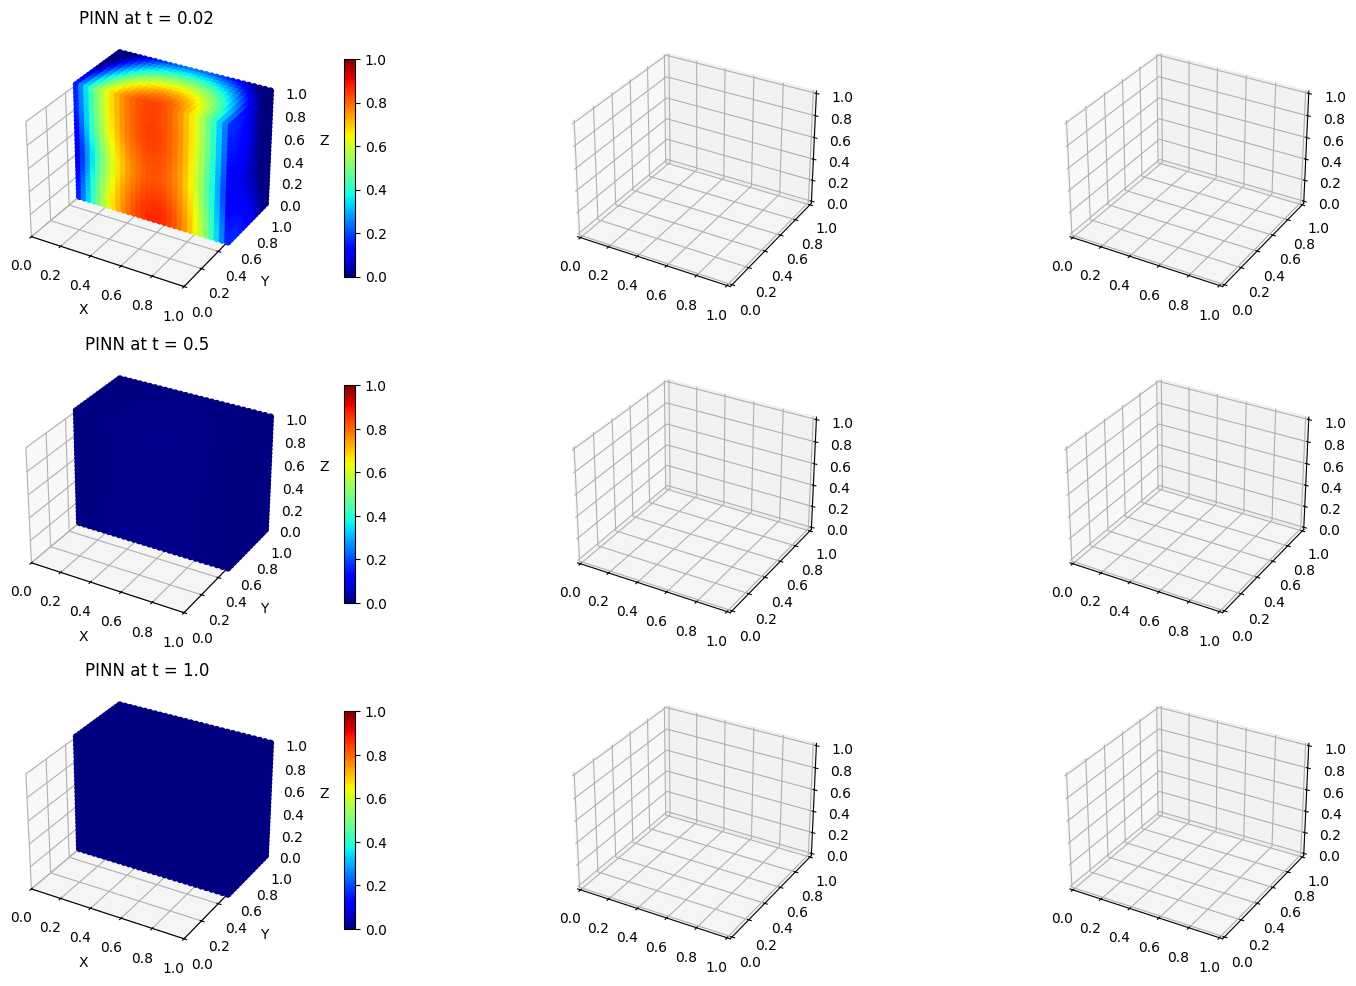

In [15]:
# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})

for i, time_point in enumerate([0.02, 0.5, 1.0]):
    # PINN Result
    t_index = int(time_point * (Nt-1))
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
    
#     # Extract the exact pore pressure at the specified time
#     u_t = u_loaded[:, :, :, t_index]
    
#     # Calculate the difference/errors
#     difference = p_pred_fixed_time - u_t
    
    # Flatten data for 3D plotting
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()
    
    p_flat = p_pred_fixed_time.flatten()
#     u_flat = u_t.flatten()
#     d_flat = difference.flatten()

    # Filter to include only the specified y range
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)
    
    # Plotting PINN result
    scatter_plot_0 = axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN at t = {time_point}')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    fig.colorbar(scatter_plot_0, ax=axs[i, 0], shrink=0.8, pad=0.15)

#     # Plotting exact solution
#     scatter_plot_1 = axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
#     axs[i, 1].set_title(f'Exact Solution at t = {time_point}')
#     axs[i, 1].set_xlabel('X')
#     axs[i, 1].set_ylabel('Y')
#     axs[i, 1].set_zlabel('Z')
#     axs[i, 1].set_xlim([0, 1])
#     axs[i, 1].set_ylim([0, 1])
#     axs[i, 1].set_zlim([0, 1])
#     fig.colorbar(scatter_plot_1, ax=axs[i, 1], shrink=0.8, pad=0.15)
    
#     # Plotting difference/errors
#     scatter_plot_2 = axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat[mask], cmap='seismic', marker='o', alpha=1.)
#     axs[i, 2].set_title(f'Difference at t = {time_point}')
#     axs[i, 2].set_xlabel('X')
#     axs[i, 2].set_ylabel('Y')
#     axs[i, 2].set_zlabel('Z')
#     axs[i, 2].set_xlim([0, 1])
#     axs[i, 2].set_ylim([0, 1])
#     axs[i, 2].set_zlim([0, 1])
#     fig.colorbar(scatter_plot_2, ax=axs[i, 2], shrink=0.8, pad=0.15)

plt.savefig("3D-Contour-Plots.png", dpi=600)
plt.show()